In [0]:
# select tensorflow 2.x
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
import tensorflow as tf
import spacy
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd drive/My Drive/ift6759/data

/content/drive/My Drive/ift6759/data


In [0]:
# loading tokenizer.py, punctuation_remover.py & unaligned.en files
from google.colab import files
files.upload() 

Saving tokenizer.py to tokenizer.py
Saving punctuation_remover.py to punctuation_remover.py


{'punctuation_remover.py': b'import argparse\r\nimport logging\r\nimport ntpath\r\nimport os\r\n\r\nimport tqdm\r\n\r\nlogger = logging.getLogger(__name__)\r\n\r\nPUNCTUATION = {",", ";", ":", "!", "?", ".", "\'", \'"\', "(", ")", "...", "[", "]", "{", "}"}\r\n\r\n\r\ndef main():\r\n    parser = argparse.ArgumentParser(\r\n        \'script to remove punctuation. Data must be already tokenized.\')\r\n    parser.add_argument(\'--input\', nargs=\'+\', help=\'input file. Note it can be more than one\')\r\n    parser.add_argument(\'--output\', help=\'path to outputs - will store files here\',\r\n                        required=True)\r\n\r\n    args = parser.parse_args()\r\n    logging.basicConfig(level=logging.INFO)\r\n\r\n    if not os.path.exists(args.output):\r\n        os.makedirs(args.output)\r\n\r\n    for current_file in args.input:\r\n        logger.info(\'tokenizing file {}\'.format(current_file))\r\n        tot_lines, removed_punctuations = remove_punctuation(current_file, args.o

## Pre-processing

In [0]:
# tokenizing, takes about 1h30. Already did it and saved files in order to mount colab to drive for future exploration
!python tokenizer.py --input=unaligned.en --output=/content/sample_data/tokenized --lang=en

INFO:__main__:will keep the case? False
INFO:__main__:will keep empty lines? False
INFO:__main__:will convert newlines to space? False
INFO:__main__:will skip lines with the following regex: []
INFO:__main__:tokenizing file unaligned.en
100% 474000/474000 [1:20:39<00:00, 97.95it/s] 
INFO:__main__:done (1 / 1) - skipped 0 lines (over 474000 - i.e., 0.00%) because empty, skipped 0 lines (over 474000 - i.e., 0.00%) because of regex


In [0]:
# removing punctuation
!python punctuation_remover.py --input=/content/sample_data/tokenized/unaligned.en --output=/content/sample_data/unaligned_nopunc

INFO:__main__:tokenizing file /content/sample_data/tokenized/unaligned.en
474000it [00:02, 171604.66it/s]
INFO:__main__:done - parsed 474000 lines and removed 993949 (punctuation) symbols


In [0]:
def create_word_doc(input_file : str):
  "creates a list with all words"
  words = []
  with open(input_file) as f:  
    for line in f:
      for word in line.lower().split():
        words.append(word)
    #words = list(set(words))
  return words

In [0]:
def remove_stop_words(lang, word_doc=None, sentences=None):
  """
  removes stop words depending on the language and depending on the input
  lang: str -> ('en' or 'fr')
  word_doc: list of str containing every word of the input file
  sentences: list of list of str representing the sentences of the input file
  """
  filtered_doc = []
  if lang == 'en':
    try:
      nlp = spacy.load("en_core_web_sm")
      spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
    except OSError:
      raise ValueError('please run the following to download the model: '
                             'python -m spacy download en_core_web_sm')
  elif lang == 'fr':
    try:
      nlp = spacy.load("fr_core_news_sm")
      spacy_stopwords = spacy.lang.fr.stop_words.STOP_WORDS
    except OSError:
      raise ValueError('please run the following to download the model: '
                             'python -m spacy download fr_core_news_sm')
  else:
    raise ValueError('lang {} not supported'.format(lang))
  
  if word_doc is not None:
    for word in word_doc:
      if word not in spacy_stopwords:
        filtered_doc.append(word)
    print('removed', len(word_doc) - len(filtered_doc), 'stopwords')

  elif sentences is not None:
    for sentence in sentences:
      sent = [word for word in sentence if word not in spacy_stopwords]
      filtered_doc.append(sent)

  return filtered_doc

In [0]:
word_doc = create_word_doc('tokenized_nopunc_unaligned.en')

In [8]:
# we can see that the punctuation remover does not include '-', this could be modified easily depending on our design decisions
word_doc[:20]

['for',
 'the',
 'second',
 'phase',
 'of',
 'the',
 'trials',
 'we',
 'just',
 'had',
 'different',
 'sizes',
 'small',
 'medium',
 'large',
 'and',
 'extra',
 '-',
 'large',
 'it']

In [9]:
filtered_tokens = remove_stop_words('en', word_doc=word_doc)

removed 4854524 stopwords


In [10]:
filtered_tokens[:10]

['second',
 'phase',
 'trials',
 'different',
 'sizes',
 'small',
 'medium',
 'large',
 'extra',
 '-']

## Word embeddings

In [0]:
def list_of_sentences(input_file):
  " creates a list of sentences "
  words = []
  with open(input_file, 'r') as f:
    for line in f:
      line = line.strip()
      words.append(line.split(" "))
  return words

In [12]:
# make a list of list of sentences and print before/after removing stop words
sentences = list_of_sentences('tokenized_nopunc_unaligned.en')
print(sentences[:4], '\n')
sentences = remove_stop_words('en', sentences=sentences)
print(sentences[:4])

[['for', 'the', 'second', 'phase', 'of', 'the', 'trials', 'we', 'just', 'had', 'different', 'sizes', 'small', 'medium', 'large', 'and', 'extra', '-', 'large', 'it', "'s", 'true'], ['geng', 'had', 'been', 'my', 'host', 'the', 'previous', 'january', 'when', 'i', 'was', 'the', 'first', 'us', 'defense', 'secretary', 'to', 'visit', 'china', 'acting', 'as', 'an', 'interlocutor', 'for', 'president', 'jimmy', 'carter', '’s', 'administration'], ['i', "'m", 'not', 'at', 'all', 'tired'], ['it', 'is', 'true', 'that', 'the', 'crisis', 'is', 'putting', 'the', 'member', 'states', 'budgets', 'under', 'pressure', 'at', 'the', 'moment']] 

[['second', 'phase', 'trials', 'different', 'sizes', 'small', 'medium', 'large', 'extra', '-', 'large', 'true'], ['geng', 'host', 'previous', 'january', 'defense', 'secretary', 'visit', 'china', 'acting', 'interlocutor', 'president', 'jimmy', 'carter', 'administration'], ['tired'], ['true', 'crisis', 'putting', 'member', 'states', 'budgets', 'pressure', 'moment']]


In [13]:
print('There are', len(sentences),"sentences in unaligned.en")

There are 474000 sentences in unaligned.en


In [16]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# for the sake of the pre-trained embeddings, I will not be removing stopwords in the sentences otherwise there is too much oov words
sentences = list_of_sentences('tokenized_nopunc_unaligned.en')
# train the model
model = Word2Vec(sentences, size=100, window=2, min_count=1, seed=0)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words[:10])

Word2Vec(vocab=60008, size=100, alpha=0.025)
['for', 'the', 'second', 'phase', 'of', 'trials', 'we', 'just', 'had', 'different']


In [17]:
# word vectors of word2vec
word_vectors = model.wv
# saving the word vectors
word_vectors.save('wordvectors')
# loading the word vectors
reloaded_vectors = KeyedVectors.load('wordvectors')
# then you can do everything that you would do with the original word vectors
# like : reloaded_vectors.similar_by_word('computer')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [31]:
print("Found %s word vectors of word2vec" % len(reloaded_vectors.vocab))

Found 59693 word vectors of word2vec


In [16]:
# access vector for one word
print(model.wv['trials'])

[-0.07791899 -0.2345535   0.42905703  0.23463583  0.07651802 -0.08713882
 -0.36118275  0.17693822  0.48205525  0.16157383  0.13352415 -0.08086362
 -0.12736306 -0.13218361  0.10681197  0.42875636 -0.31715858 -0.01096464
 -0.14425828  0.2629153  -0.08394623  0.46243575  0.2956793   0.3587908
  0.14930563 -0.6716609   0.19027396  0.10168021  0.20657474 -0.5313685
  0.11076208 -0.60807043 -0.02768914 -0.14102021 -0.41052777  0.1376199
 -0.3321069   0.46940333 -0.03463029 -0.02277536  0.18874967 -0.00720735
  0.2718243   0.16026554 -0.24115555  0.05837119  0.56308657 -0.38954264
  0.1211292  -0.20882297 -0.24718614 -0.39581898  0.23866177  0.2508282
 -0.04695142 -0.0042771  -0.37739235  0.13699728  0.1566623   0.08627667
 -0.40006799  0.05918857 -0.38084963  0.14330687  0.34714493  0.35953957
  0.3486214   0.2175911  -0.05509248 -0.27492717 -0.51909894 -0.19181764
 -0.17222056  0.22600386  0.04964686  0.28793523 -0.16695467 -0.08882768
  0.00424347 -0.06314412 -0.32101837  0.16464606  0.115

In [17]:
model.wv.similar_by_word('computer')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('computers', 0.857736349105835),
 ('software', 0.8481405377388),
 ('splicing', 0.8111925721168518),
 ('machine', 0.8111383318901062),
 ('device', 0.8080402612686157),
 ('battery', 0.8070384860038757),
 ('entertainment', 0.8010045289993286),
 ('cell', 0.7959043383598328),
 ('machines', 0.7943541407585144),
 ('web', 0.7930951118469238)]

In [0]:
# visualizing, function I took inspiration from online for now
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def display_closestwords(model, word):
  
  arr = np.empty((0,100), dtype='f')
  word_labels = [word]

  # get close words
  close_words = model.wv.similar_by_word(word)
  
  # add the vector for each of the closest words to the array
  arr = np.append(arr, np.array([model.wv[word]]), axis=0)
  for wrd_score in close_words:
      wrd_vector = model.wv[wrd_score[0]]
      word_labels.append(wrd_score[0])
      arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
  tsne = TSNE(n_components=2, random_state=0)
  np.set_printoptions(suppress=True)
  Y = tsne.fit_transform(arr)

  x_coords = Y[:, 0]
  y_coords = Y[:, 1]
  # display scatter plot
  plt.scatter(x_coords, y_coords)

  for label, x, y in zip(word_labels, x_coords, y_coords):
      plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
  plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
  plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
  plt.show()

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


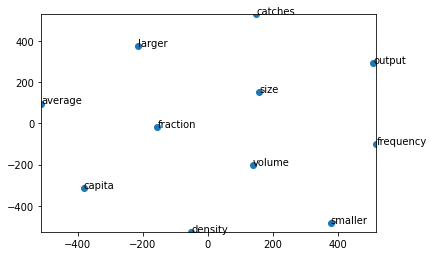

In [19]:
display_closestwords(model, 'size')